In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [18]:
# 数据
transform = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = r"D:\cc\Desktop\data"
train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [19]:
# 定义主VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# 定义残差VAE
class ResidualVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim, latent_dim):
        super(ResidualVAE, self).__init__()
        self.cond_dim = cond_dim
        self.input_dim = input_dim

   
        self.fc1 = nn.Linear(input_dim + cond_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    
        self.fc3 = nn.Linear(latent_dim + cond_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, d, x_prime):
        h = torch.relu(self.fc1(torch.cat([d, x_prime], dim=1)))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_prime):
        h = torch.relu(self.fc3(torch.cat([z, x_prime], dim=1)))
        return self.fc4(h)

    def forward(self, d, x_prime):
        mu, logvar = self.encode(d, x_prime)
        z = self.reparameterize(mu, logvar)
        d_prime = self.decode(z, x_prime)
        return d_prime, mu, logvar


# 模型参数
input_dim = 28 * 28
hidden_dim = 200
latent_dim = 10

In [20]:
# 初始化模型
model_vae1 = VAE(input_dim, hidden_dim, latent_dim)
model_vae2 = ResidualVAE(input_dim, input_dim, hidden_dim, latent_dim)

# 训练主VAE
optimizer_vae1 = optim.Adam(model_vae1.parameters(), lr=1e-4)



def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

'''
def loss_function(recon_d, d, mu, logvar):
    recon_loss = F.l1_loss(recon_d, d, reduction='sum') 
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld
'''
num_epochs = 20
for epoch in range(num_epochs):
    model_vae1.train()
    train_loss = 0
    for i, (data, _) in enumerate(train_loader):
        data = data.to('cpu')
        optimizer_vae1.zero_grad()
        recon_batch, mu, logvar = model_vae1(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_vae1.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch [1/20], Loss: 70.2505
Epoch [2/20], Loss: 46.5966
Epoch [3/20], Loss: 41.4655
Epoch [4/20], Loss: 38.8444
Epoch [5/20], Loss: 37.2515
Epoch [6/20], Loss: 36.2372
Epoch [7/20], Loss: 35.5683
Epoch [8/20], Loss: 35.0340
Epoch [9/20], Loss: 34.6053
Epoch [10/20], Loss: 34.2665
Epoch [11/20], Loss: 33.9776
Epoch [12/20], Loss: 33.7123
Epoch [13/20], Loss: 33.5185
Epoch [14/20], Loss: 33.3000
Epoch [15/20], Loss: 33.1203
Epoch [16/20], Loss: 32.9777
Epoch [17/20], Loss: 32.8282
Epoch [18/20], Loss: 32.6674
Epoch [19/20], Loss: 32.5493
Epoch [20/20], Loss: 32.4527


In [21]:
# 准备残差数据并训练残差VAE
model_vae1.eval()
residuals = []
x_primes = []

with torch.no_grad():
    for data, _ in train_loader:
        data = data.to('cpu').view(-1, 784)
        x_prime, _, _ = model_vae1(data)
        d = data - x_prime
        residuals.append(d.cpu())
        x_primes.append(x_prime.cpu())

residuals = torch.cat(residuals)
x_primes = torch.cat(x_primes)

residual_dataset = torch.utils.data.TensorDataset(residuals, x_primes)
residual_loader = torch.utils.data.DataLoader(residual_dataset, batch_size=64, shuffle=True)

# 训练残差VAE
optimizer_vae2 = optim.Adam(model_vae2.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model_vae2.train()
    train_loss = 0
    for d_batch, x_prime_batch in residual_loader:
        d_batch = d_batch.to('cpu')
        x_prime_batch = x_prime_batch.to('cpu')

        optimizer_vae2.zero_grad()
        d_prime, mu, logvar = model_vae2(d_batch, x_prime_batch)
        loss = loss_function(d_prime, d_batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_vae2.step()
    print(f'Residual VAE Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(residual_loader.dataset):.4f}')


Residual VAE Epoch [1/20], Loss: 22.6024
Residual VAE Epoch [2/20], Loss: 22.3321
Residual VAE Epoch [3/20], Loss: 22.1700
Residual VAE Epoch [4/20], Loss: 21.9816
Residual VAE Epoch [5/20], Loss: 21.8230
Residual VAE Epoch [6/20], Loss: 21.7009
Residual VAE Epoch [7/20], Loss: 21.5980
Residual VAE Epoch [8/20], Loss: 21.5144
Residual VAE Epoch [9/20], Loss: 21.4381
Residual VAE Epoch [10/20], Loss: 21.3715
Residual VAE Epoch [11/20], Loss: 21.3082
Residual VAE Epoch [12/20], Loss: 21.2542
Residual VAE Epoch [13/20], Loss: 21.2099
Residual VAE Epoch [14/20], Loss: 21.1667
Residual VAE Epoch [15/20], Loss: 21.1290
Residual VAE Epoch [16/20], Loss: 21.0958
Residual VAE Epoch [17/20], Loss: 21.0698
Residual VAE Epoch [18/20], Loss: 21.0380
Residual VAE Epoch [19/20], Loss: 21.0167
Residual VAE Epoch [20/20], Loss: 20.9884


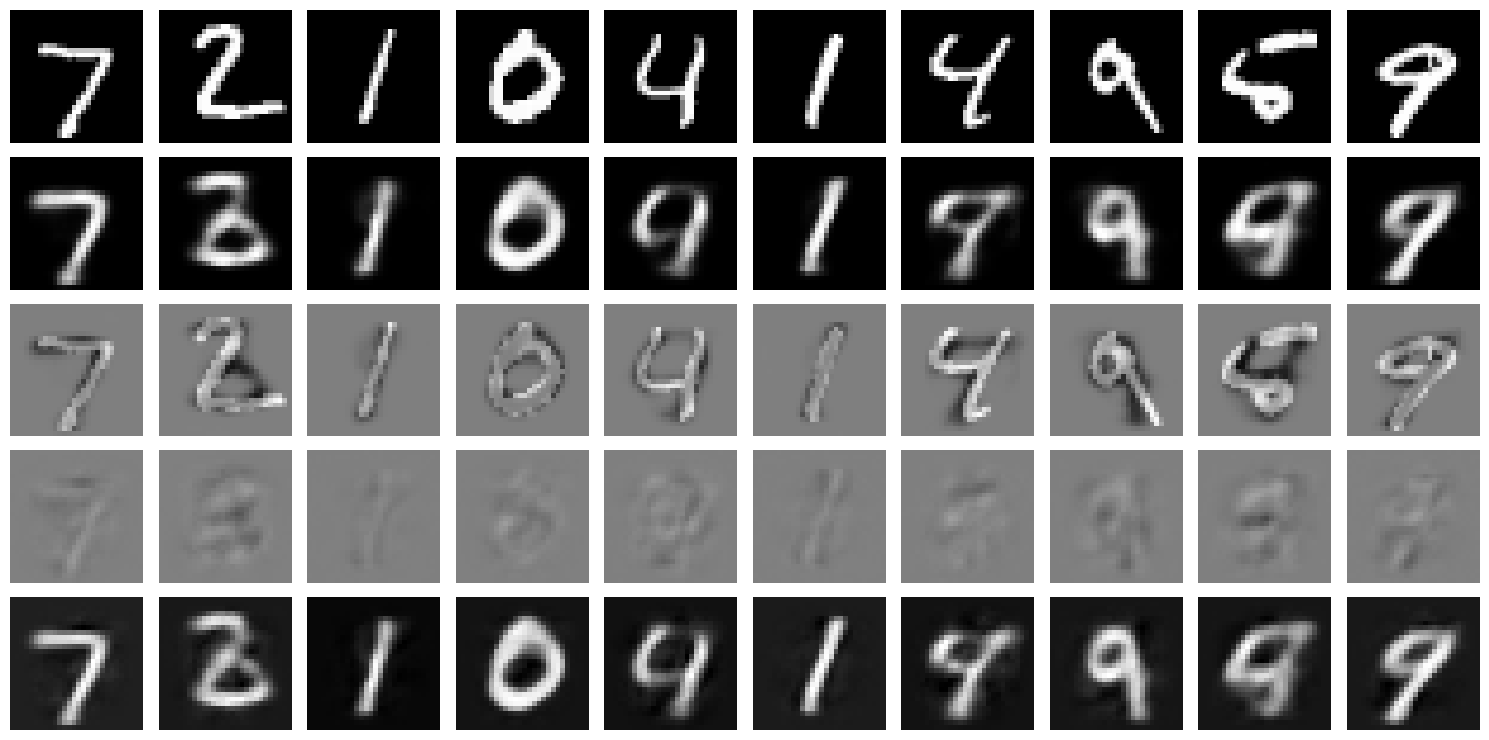

In [22]:
# 可视化
model_vae1.eval()
model_vae2.eval()

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:10].to('cpu').view(-1, 784)

    x_prime, _, _ = model_vae1(data)
    d = data - x_prime
    d_prime, _, _ = model_vae2(d, x_prime)
    x_final = x_prime + d_prime

    data_img = data.view(-1, 1, 28, 28).cpu()
    x_prime_img = x_prime.view(-1, 1, 28, 28).cpu()
    d_img = d.view(-1, 1, 28, 28).cpu()
    d_prime_img = d_prime.view(-1, 1, 28, 28).cpu()
    x_final_img = x_final.view(-1, 1, 28, 28).cpu()

    fig, axes = plt.subplots(5, 10, figsize=(15, 7.5))
    for i in range(10):
        axes[0, i].imshow(data_img[i][0], cmap='gray')
        axes[1, i].imshow(x_prime_img[i][0], cmap='gray')
        axes[2, i].imshow(d_img[i][0], cmap='gray', vmin=-1, vmax=1)
        axes[3, i].imshow(d_prime_img[i][0], cmap='gray', vmin=-1, vmax=1)
        axes[4, i].imshow(x_final_img[i][0], cmap='gray')

        for ax in axes[:, i]:
            ax.axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=10)
    axes[1, 0].set_ylabel("X'", fontsize=10)
    axes[2, 0].set_ylabel('D', fontsize=10)
    axes[3, 0].set_ylabel("D'", fontsize=10)
    axes[4, 0].set_ylabel("X'+D'", fontsize=10)

    plt.tight_layout()
    plt.show()